In [ ]:

import pandas as pd
import numpy as np
import pickle
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import seaborn as sns
import string
import re
import os
import operator
import json
from collections import Counter
from collections import defaultdict
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import seaborn as sns
import numpy
import keras
from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence


from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers.wrappers import Bidirectional

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Q1 

## Download the dataset and read to df

Columns explanation for dataset : 
* target: the polarity of the tweet (0 = negative, 2 = neutral, 4 = positive)
* ids: The id of the tweet ( 2087)
* date: the date of the tweet (Sat May 16 23:58:44 UTC 2009)
* flag: The query (lyx). If there is no query, then this value is NO_QUERY.
* user: the user that tweeted (robotickilldozr)
* text: the text of the tweet (Lyx is cool)

In [ ]:
data_path = "/content/drive/My Drive/training.1600000.processed.noemoticon.csv"

In [ ]:
# read df
colnames=['target', 'id', 'date', 'flag','user','text']
df=pd.read_csv(data_path,encoding='ISO-8859-1',sep=",",names=colnames)

df.head()


,target,id,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [ ]:
df.dtypes

target     int64
id         int64
date      object
flag      object
user      object
text      object
dtype: object

## select first 100,000 tweets- neg and pos

In [ ]:
df.shape

(1600000, 6)

In [ ]:
# remove duplicates tweets 
df= df.drop_duplicates(subset=['text'], keep='last')
print("df shape: ", df.shape)

df shape:  (1581466, 6)


In [ ]:
# select 50,000 records of positive_df sentimant and write to csv : positive_df
positive_df=df.query(' target == 4' ).head(50000)
# save only the columns- text and target (label).  Others columns are not relavent for task
# we assump that the tweets can be negative\positive anytime and for everyone
positive_df=positive_df[['text','target']].copy()
positive_df.to_csv('positive_df.csv')

positive_df.head()

,text,target
800000,I LOVE @Health4UandPets u guys r the best!!,4
800001,im meeting up with one of my besties tonight! ...,4
800002,"@DaRealSunisaKim Thanks for the Twitter add, S...",4
800003,Being sick can be really cheap when it hurts t...,4
800004,@LovesBrooklyn2 he has that effect on everyone,4


In [ ]:
print("positive_df shape: ", positive_df.shape)

positive_df shape:  (50000, 2)


In [ ]:
# check there are no duplicates
positive_df['text'].nunique()


50000

In [ ]:
# select 50,000 records of negative sentimant and write to csv : negative_df
negative_df=df.query(' target == 0' ).head(50000)
# save only the columns- text and target (label).  Others columns are not relavent for task
# we assump that the tweets can be negative\positive anytime and for everyone 
negative_df=negative_df[['text','target']].copy()
negative_df.to_csv('negative_df.csv')

negative_df.head()

,text,target
0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",0
1,is upset that he can't update his Facebook by ...,0
2,@Kenichan I dived many times for the ball. Man...,0
3,my whole body feels itchy and like its on fire,0
4,"@nationwideclass no, it's not behaving at all....",0


In [ ]:
print("negative_df shape: ", negative_df.shape)

negative_df shape:  (50000, 2)


In [ ]:
# check there are no duplicates
positive_df['text'].nunique()


50000

In [ ]:
# read dfs:
negative_df = pd.read_csv("negative_df.csv", sep=",")
positive_df= pd.read_csv("positive_df.csv", sep=",")

## Text pre-processing

In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
# tweets pre-processing
punctuation = list(string.punctuation)
stop = stopwords.words('english') + punctuation + ['rt',"",'‘','ן',"“",'via', 'the',u'\u2019',u'\u2026','The',u'de',u'\xe9']+['\U0001f970','\U0001f97a','\U0001f974']
emoticons_str = r"""
    (?:
        [:=;] # Eyes
        [oO\-]? # Nose (optional)
        [D\)\]\(\]/\\OpP] # Mouth
    )"""
regex_str = [
    emoticons_str,
    r'<[^>]+>',  # HTML tags
    r'(?:@[\w_]+)',  # @-mentions
    r"(?:\#+[\w_]+[\w\'_\-]*[\w_]+)",  # hash-tags
    r'http[s]?://(?:[a-z]|[0-9]|[$-_@.&+]|[!*\(\)]|(?:%[0-9a-f][0-9a-f]))+',  # URLs
    r'(?:(?:\d+,?)+(?:\.?\d+)?)',  # numbers
    r"(?:[a-z][a-z'\-_]+[a-z])",  # words with - and '
    r'(?:[\w_]+)', # other words
    r'(?:\S)' # anything else
]

In [ ]:
!pip install emoji
import emoji
# cconvert emojis and simileis
def cconvert_emoji(text):
  without_emoji=emoji.demojize(text)
  # if without_emoji!=text:
  #   without_emoji=without_emoji.replace(":","")
  return without_emoji

In [ ]:
# Tokenization
tokens_re = re.compile(r'('+'|'.join(regex_str)+')', re.VERBOSE | re.IGNORECASE)
emoticon_re = re.compile(r'^'+emoticons_str+'$', re.VERBOSE | re.IGNORECASE)
# split the text to tokens 
def tokenize(s):
    return tokens_re.findall(s)
# remove common and specilase terms 
def preprocess(s, lowercase=False):
    tokens = tokenize(s)
    if lowercase:
        tokens = [token if emoticon_re.search(token) else token.lower() for token in tokens]
        tokens[:] = [term for term in tokens if (term !='')or(term !="")] #remove empty
    return tokens


In [ ]:
# counting
# Terms Counting - count how many times term appears
def count_terms(curr_df):
    count_all = Counter()
    for index, row in curr_df.iterrows():
        if 'Text' in curr_df.columns:
          curr_tweet = row['Text']
        elif 'text' in curr_df.columns:
          curr_tweet = row['text']
        if len(curr_tweet) < 1:
            continue
        # Create a list with all the terms
        curr_tweet= cconvert_emoji(curr_tweet)
        curr_tweet_tokens = preprocess(curr_tweet, True)
        terms_all = [term for term in curr_tweet_tokens if term not in stop]
        if '' in terms_all:
          terms_all.remove('')
        # Update the counter
        count_all.update(terms_all)
    return count_all

## Data exploration

In [ ]:
# calculate posts average length 
def get_average_text_len(df):
  avge_length = 0
  all_terms=df.text.values
  for post in all_terms:
    avge_length = avge_length + len(str(post).split(" "))
  total_avge=avge_length / df.text.values.size
  return total_avge


*   positive sentimant explorarion 



In [ ]:
# count positive terms frequency
pos_counter= count_terms(positive_df)
print("Number of terms in positive category:",len(pos_counter))

Number of terms in positive category: 62057


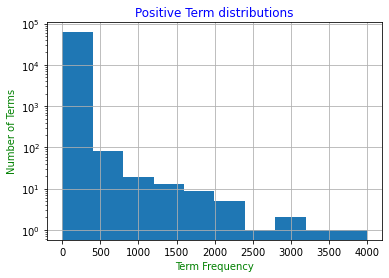

In [ ]:
#positive terms distribution
term_frequency = pd.DataFrame(pos_counter.items(), columns=['Term','Frequency'])
fig = term_frequency.hist(column="Frequency", bins=10)
plt.title("Positive Term distributions",color='blue')
plt.xlabel("Term Frequency",color='green')
plt.ylabel("Number of Terms",color='green')
ax = plt.gca()
ax.set_yscale('log')
plt.show()

In [ ]:
# average length - positive tweets
print('average length of positive post: {0}'.format(get_average_text_len(positive_df)))

average length of positive post: 14.07928



*   negative sentimant explorarion 



In [ ]:
# count negative terms frequency
neg_counter= count_terms(negative_df)
print("Number of terms in negative category:",len(neg_counter))

Number of terms in negative category: 51294


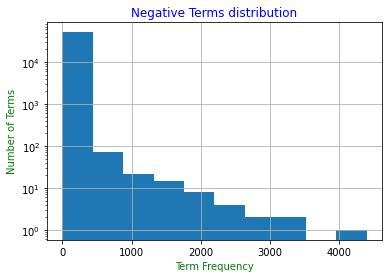

In [ ]:
#negative terms distribution
term_frequency = pd.DataFrame(neg_counter.items(), columns=['Term','Frequency'])
fig = term_frequency.hist(column="Frequency", bins=10)
plt.title("Negative Terms distribution",color='blue')
plt.xlabel("Term Frequency",color='green')
plt.ylabel("Number of Terms",color='green')
ax = plt.gca()
ax.set_yscale('log')
plt.show()

In [ ]:
# average length - negative tweets
print('average length of negative post: {0}'.format(get_average_text_len(negative_df)))

average length of negative post: 14.83298


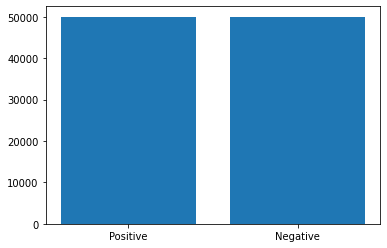

In [ ]:
# positive and negative distribution :

# conect 2 dfs 
df_together=pd.concat([positive_df, negative_df],ignore_index=True)

class_count = df_together.groupby(['target'])['target'].count()
plt.bar(np.array(["Positive","Negative"]),class_count)
plt.show()

*  check popular terms for each class

In [ ]:
#top 10 terms - positive - Finding 10 highest values
high_pos = pos_counter.most_common(10)

high_pos

[('good', 3990),
 ("i'm", 3486),
 ('quot', 2867),
 ('day', 2818),
 ('love', 2708),
 ('like', 2375),
 ('get', 2248),
 ('thanks', 2141),
 ('going', 2051),
 ('lol', 2006)]

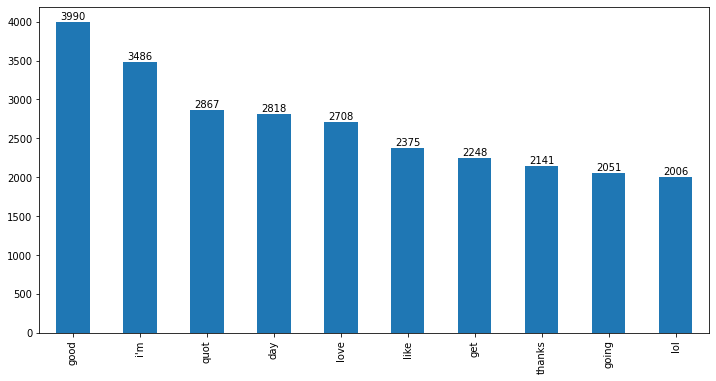

In [ ]:
# positive top 10 terms plot
x_labels = [val[0] for val in high_pos]
y_labels = [val[1] for val in high_pos]
plt.figure(figsize=(12, 6))
ax = pd.Series(y_labels).plot(kind='bar')
ax.set_xticklabels(x_labels)

rects = ax.patches

for rect, label in zip(rects, y_labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

In [ ]:
#top 10 terms - negative - Finding 10 highest values
high_neg = neg_counter.most_common(10)
high_neg

[("i'm", 4392),
 ('work', 3451),
 ('go', 3096),
 ('get', 2861),
 ('day', 2815),
 ('today', 2614),
 ('back', 2606),
 ('like', 2446),
 ('going', 2226),
 ('got', 2161)]

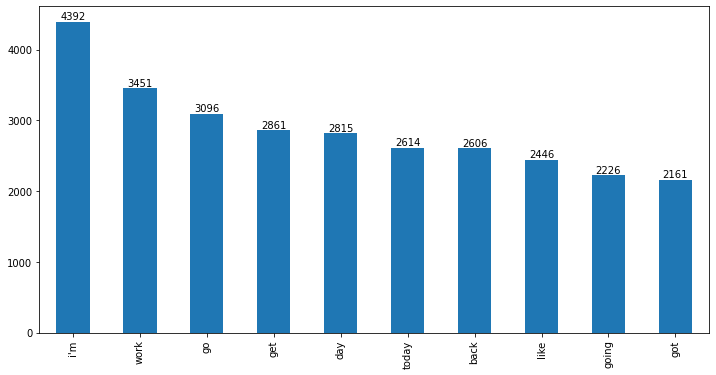

In [ ]:
# negative top 10 terms plot
x_labels = [val[0] for val in high_neg]
y_labels = [val[1] for val in high_neg]
plt.figure(figsize=(12, 6))
ax = pd.Series(y_labels).plot(kind='bar')
ax.set_xticklabels(x_labels)

rects = ax.patches

for rect, label in zip(rects, y_labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

In [ ]:
# most popular terms for each class: 
top_terms_df = pd.DataFrame()
top_terms_df['Positive Terms']= high_pos
top_terms_df['Negative Terms']=high_neg #top 10 terms - negative

top_terms_df

,Positive Terms,Negative Terms
0,"(good, 3990)","(i'm, 4392)"
1,"(i'm, 3486)","(work, 3451)"
2,"(quot, 2867)","(go, 3096)"
3,"(day, 2818)","(get, 2861)"
4,"(love, 2708)","(day, 2815)"
5,"(like, 2375)","(today, 2614)"
6,"(get, 2248)","(back, 2606)"
7,"(thanks, 2141)","(like, 2446)"
8,"(going, 2051)","(going, 2226)"
9,"(lol, 2006)","(got, 2161)"


We can see, that there are some words that similar between negative and positive common words. 
We also can see that there are words which unique for each sentiment.


# Q2

In [ ]:
negative_df

,Unnamed: 0,text,target
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",0
1,1,is upset that he can't update his Facebook by ...,0
2,2,@Kenichan I dived many times for the ball. Man...,0
3,3,my whole body feels itchy and like its on fire,0
4,4,"@nationwideclass no, it's not behaving at all....",0
...,...,...,...
49995,51178,@tommertron Seriously! I've already read about...,0
49996,51179,"@DazzleMeThis psshhtt, yea i reckon =P",0
49997,51180,@tifkin Have you called to see about a refund ...,0
49998,51181,is sitting through a boring exam review sessio...,0


In [ ]:
positive_df

,Unnamed: 0,text,target
0,800000,I LOVE @Health4UandPets u guys r the best!!,4
1,800001,im meeting up with one of my besties tonight! ...,4
2,800002,"@DaRealSunisaKim Thanks for the Twitter add, S...",4
3,800003,Being sick can be really cheap when it hurts t...,4
4,800004,@LovesBrooklyn2 he has that effect on everyone,4
...,...,...,...
49995,850481,@libbyoliver A bit like myself then.,4
49996,850482,Good morning everyone! Hope you have a great d...,4
49997,850483,How many times have you wanted to say this to ...,4
49998,850484,@mja320 Thanks!! I just picked out prints I wa...,4


In [ ]:
df=pd.concat([positive_df, negative_df],ignore_index=True)

df

,Unnamed: 0,text,target
0,800000,I LOVE @Health4UandPets u guys r the best!!,4
1,800001,im meeting up with one of my besties tonight! ...,4
2,800002,"@DaRealSunisaKim Thanks for the Twitter add, S...",4
3,800003,Being sick can be really cheap when it hurts t...,4
4,800004,@LovesBrooklyn2 he has that effect on everyone,4
...,...,...,...
99995,51178,@tommertron Seriously! I've already read about...,0
99996,51179,"@DazzleMeThis psshhtt, yea i reckon =P",0
99997,51180,@tifkin Have you called to see about a refund ...,0
99998,51181,is sitting through a boring exam review sessio...,0


In [ ]:
#helper functions

def to_binary(num):
  if num==0:
    return 0
  else:
    return 1



df['target']=df['target'].apply(to_binary)


In [ ]:
df


,Unnamed: 0,text,target
0,800000,I LOVE @Health4UandPets u guys r the best!!,1
1,800001,im meeting up with one of my besties tonight! ...,1
2,800002,"@DaRealSunisaKim Thanks for the Twitter add, S...",1
3,800003,Being sick can be really cheap when it hurts t...,1
4,800004,@LovesBrooklyn2 he has that effect on everyone,1
...,...,...,...
99995,51178,@tommertron Seriously! I've already read about...,0
99996,51179,"@DazzleMeThis psshhtt, yea i reckon =P",0
99997,51180,@tifkin Have you called to see about a refund ...,0
99998,51181,is sitting through a boring exam review sessio...,0


In [ ]:

X = df['text']
y = df['target']

## LSTM model

In [ ]:

max_len=50
vocabulary_size=20000
numpy.random.seed(7)

tokenizer = Tokenizer(num_words=vocabulary_size)
tokenizer.fit_on_texts(X.to_list())
X = tokenizer.texts_to_sequences(X.to_list())
X = pad_sequences(X, maxlen=max_len)

In [ ]:
X.shape

(100000, 50)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42,stratify=y)

### run LSTM with fixed parameters

In [ ]:
#build model
keras.backend.clear_session()

first_model = Sequential()
first_model.add(Embedding(input_dim=vocabulary_size,
                    output_dim=30,
                    input_length=50),)
first_model.add(Dropout(0.3))
first_model.add(LSTM(64,dropout=0.3))
first_model.add(Dropout(0.3))
first_model.add(Dense(1, activation='sigmoid'))
first_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print(first_model.summary())


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 50, 30)            600000    
_________________________________________________________________
dropout (Dropout)            (None, 50, 30)            0         
_________________________________________________________________
lstm (LSTM)                  (None, 64)                24320     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 624,385
Trainable params: 624,385
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
first_history=first_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20,batch_size= 256)


Epoch 1/20
313/313 [==============================] - 6s 14ms/step - loss: 0.6152 - accuracy: 0.6431 - val_loss: 0.4694 - val_accuracy: 0.7804
Epoch 2/20
313/313 [==============================] - 4s 12ms/step - loss: 0.4463 - accuracy: 0.7962 - val_loss: 0.4564 - val_accuracy: 0.7860
Epoch 3/20
313/313 [==============================] - 4s 12ms/step - loss: 0.4117 - accuracy: 0.8164 - val_loss: 0.4625 - val_accuracy: 0.7857
Epoch 4/20
313/313 [==============================] - 4s 12ms/step - loss: 0.3870 - accuracy: 0.8298 - val_loss: 0.4728 - val_accuracy: 0.7832
Epoch 5/20
313/313 [==============================] - 4s 12ms/step - loss: 0.3662 - accuracy: 0.8401 - val_loss: 0.4640 - val_accuracy: 0.7846
Epoch 6/20
313/313 [==============================] - 4s 13ms/step - loss: 0.3538 - accuracy: 0.8469 - val_loss: 0.4823 - val_accuracy: 0.7777
Epoch 7/20
313/313 [==============================] - 4s 12ms/step - loss: 0.3370 - accuracy: 0.8548 - val_loss: 0.4752 - val_accuracy: 0.7790

In [ ]:
scores = first_model.predict(X_test)
pred_test=np.where(scores>0.5,1,0)

scores = first_model.predict(X_train)
pred_train=np.where(scores>0.5,1,0)


In [ ]:
score = metrics.accuracy_score(y_test, pred_test)

print("test accuracy score:   %0.3f" % (score*100))
print()
print(metrics.classification_report(y_test, pred_test))

test accuracy score:   76.155

              precision    recall  f1-score   support

           0       0.75      0.78      0.77     10000
           1       0.77      0.74      0.76     10000

    accuracy                           0.76     20000
   macro avg       0.76      0.76      0.76     20000
weighted avg       0.76      0.76      0.76     20000



In [ ]:
score = metrics.accuracy_score(y_train, pred_train)
print("train accuracy score:   %0.3f" % (score*100))
print()
print(metrics.classification_report(y_train, pred_train))

train accuracy score:   93.374

              precision    recall  f1-score   support

           0       0.92      0.95      0.93     40000
           1       0.95      0.92      0.93     40000

    accuracy                           0.93     80000
   macro avg       0.93      0.93      0.93     80000
weighted avg       0.93      0.93      0.93     80000



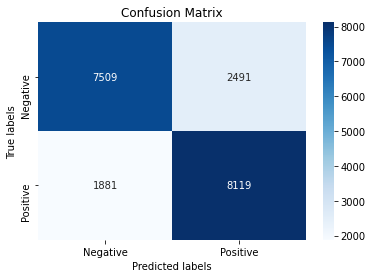

In [ ]:
cnf_matrix = metrics.confusion_matrix(y_test, pred_test)
ax= plt.subplot()
sns.heatmap(cnf_matrix, annot=True, ax = ax,cmap='Blues', fmt='g'); #annot=True to annotate cells

ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Negative', 'Positive']); ax.yaxis.set_ticklabels(['Negative', 'Positive']);



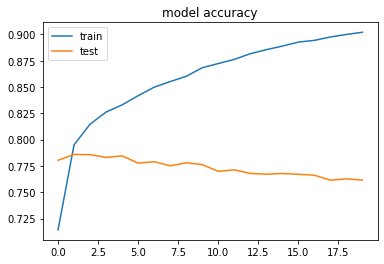

In [ ]:
plt.plot(first_history.history['accuracy'], label='train')
plt.plot(first_history.history['val_accuracy'], label='test')
plt.title('model accuracy')
plt.legend(loc='upper left')
plt.show()

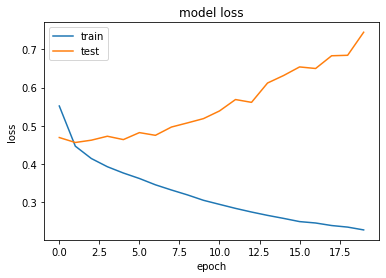

In [ ]:
plt.plot(first_history.history['loss'])
plt.plot(first_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### parameter tunning for LSTM

In [ ]:
# Use scikit-learn to grid search the batch size and epochs
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier

def create_model(optimizer='adam',dropout_rate=0.3,input_len=50, out_dim=30):
  model = Sequential()
  model.add(Embedding(input_dim=vocabulary_size,
                      output_dim=30,
                      input_length=50),)
  model.add(Dropout(dropout_rate))
  model.add(LSTM(64,dropout=dropout_rate))
  model.add(Dropout(dropout_rate))
  model.add(Dense(1, activation='sigmoid'))
  model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
  return model


# create model
model = KerasClassifier(build_fn=create_model, verbose=2)
# define the grid search parameters
#optimizer = ['SGD', 'RMSprop','Adam', 'Adamax', 'Nadam']
epochs = [10,20] 
batches = [128 ,256] 
dropout_rate = [0.0, 0.1, 0.2, 0.4]
input_lengths=[100,50, 30]
output_dim=[100,50,30]
param_grid = dict(nb_epoch=epochs, batch_size=batches,dropout_rate=dropout_rate,input_len=input_lengths, out_dim=output_dim)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3, verbose=10)

grid_result = grid.fit(X_train, y_train)
#print(grid_re)
#pickle.dump(grid_result, open("/content/drive/My Drive/keras-cls", "wb"))



Fitting 3 folds for each of 144 candidates, totalling 432 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   16.7s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   27.6s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   59.5s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:  6.3min
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:  7.6min
[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed:  8.7min
[Parallel(n_jobs=-1)]: Done 109 tasks      | elapsed: 10.2min
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed: 11.5min
[Parallel(n_jobs=-1)]: Done 141 tasks      | elapsed: 13

625/625 - 7s - loss: 0.5077 - accuracy: 0.7492


In [ ]:
print(grid_result.best_score_)
print(grid_result.best_params_)

0.7808374961217245
{'batch_size': 128, 'dropout_rate': 0.0, 'input_len': 50, 'nb_epoch': 20, 'out_dim': 30}


In [ ]:
#run the best model
#optimizer='adam',dropout_rate=0.3, input_len= 50, out_dim=30

best_lstm= create_model(dropout_rate=grid_result.best_params_['dropout_rate'],input_len=grid_result.best_params_['input_len'], out_dim=grid_result.best_params_['out_dim'])
best_hist=best_lstm.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=grid_result.best_params_['nb_epoch'],batch_size= grid_result.best_params_['batch_size'])



Epoch 1/20
625/625 [==============================] - 9s 12ms/step - loss: 0.5650 - accuracy: 0.6976 - val_loss: 0.4592 - val_accuracy: 0.7847
Epoch 2/20
625/625 [==============================] - 7s 11ms/step - loss: 0.4106 - accuracy: 0.8173 - val_loss: 0.4587 - val_accuracy: 0.7811
Epoch 3/20
625/625 [==============================] - 7s 10ms/step - loss: 0.3691 - accuracy: 0.8390 - val_loss: 0.4699 - val_accuracy: 0.7810
Epoch 4/20
625/625 [==============================] - 7s 11ms/step - loss: 0.3316 - accuracy: 0.8562 - val_loss: 0.4903 - val_accuracy: 0.7786
Epoch 5/20
625/625 [==============================] - 7s 11ms/step - loss: 0.2908 - accuracy: 0.8766 - val_loss: 0.5220 - val_accuracy: 0.7760
Epoch 6/20
625/625 [==============================] - 7s 11ms/step - loss: 0.2527 - accuracy: 0.8932 - val_loss: 0.6278 - val_accuracy: 0.7678
Epoch 7/20
625/625 [==============================] - 7s 11ms/step - loss: 0.2181 - accuracy: 0.9093 - val_loss: 0.7102 - val_accuracy: 0.7649

In [ ]:
# Final evaluation of the model
scores = best_lstm.predict(X_test)
y_pred=np.where(scores>0.5,1,0)


In [ ]:
score = metrics.accuracy_score(y_test, y_pred)

print("test accuracy score:   %0.3f" % (score*100))
print()
print(metrics.classification_report(y_test, y_pred))

test accuracy score:   74.065

              precision    recall  f1-score   support

           0       0.74      0.74      0.74     10000
           1       0.74      0.74      0.74     10000

    accuracy                           0.74     20000
   macro avg       0.74      0.74      0.74     20000
weighted avg       0.74      0.74      0.74     20000



In [ ]:
scores = best_lstm.predict(X_train)
pred_train=np.where(scores>0.5,1,0)

score = metrics.accuracy_score(y_train, pred_train)
print("train accuracy score:   %0.3f" % (score*100))
print()
print(metrics.classification_report(y_train, pred_train))




train accuracy score:   98.345

              precision    recall  f1-score   support

           0       0.98      0.98      0.98     40000
           1       0.98      0.98      0.98     40000

    accuracy                           0.98     80000
   macro avg       0.98      0.98      0.98     80000
weighted avg       0.98      0.98      0.98     80000



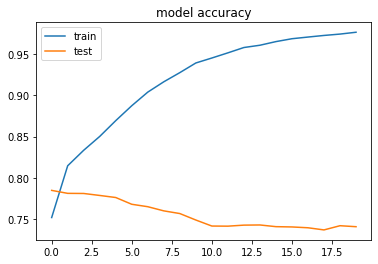

In [ ]:
plt.plot(best_hist.history['accuracy'], label='train')
plt.plot(best_hist.history['val_accuracy'], label='test')
plt.title('model accuracy')
plt.legend(loc='upper left')
plt.show()

## Machine learning algorithm -SVM



In [ ]:
X = df['text']
y = df['target']

# same train and test from question 2

X_train, X_test, y_train, y_test =train_test_split(X, y, test_size=0.2, random_state=42,stratify=y)



### run SVM with no parameters


In [ ]:

#TF-IDF
tf_vec = TfidfVectorizer(ngram_range=(1,1))
X_train_tf = tf_vec.fit_transform(X_train)
X_test_tf=tf_vec.transform(X_test)

In [ ]:


svm= SGDClassifier(random_state=42, alpha=0.0001)
svm.fit(X_train_tf, y_train)
pred_test = svm.predict(X_test_tf)
pred_train = svm.predict(X_train_tf)


score = metrics.accuracy_score(y_test, pred_test)

print("test accuracy score:   %0.3f" % (score*100))
print()
print(metrics.classification_report(y_test, pred_test))



test accuracy score:   77.780

              precision    recall  f1-score   support

           0       0.79      0.76      0.77     10000
           1       0.77      0.80      0.78     10000

    accuracy                           0.78     20000
   macro avg       0.78      0.78      0.78     20000
weighted avg       0.78      0.78      0.78     20000



In [ ]:
score = metrics.accuracy_score(y_train, pred_train)
print("train accuracy score:   %0.3f" % (score*100))
print()
print(metrics.classification_report(y_train, pred_train))




train accuracy score:   80.041

              precision    recall  f1-score   support

           0       0.82      0.77      0.79     40000
           1       0.79      0.83      0.81     40000

    accuracy                           0.80     80000
   macro avg       0.80      0.80      0.80     80000
weighted avg       0.80      0.80      0.80     80000



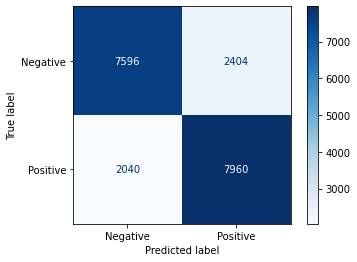

In [ ]:
from sklearn.metrics import plot_confusion_matrix
class_names = ['Negative', 'Positive']
plot_confusion_matrix(svm, X_test_tf, y_test,display_labels=class_names,normalize=None, values_format = '.0f',cmap=plt.cm.Blues)

### parameter tunning for SVM

In [ ]:
import os
import pickle

cv_params = {'vect__max_df': (0.4,0.5,0.6,0.7,0.8,0.9),
              'vect__max_features':(20000,10000),
              'vect__ngram_range': ((1, 1), (1, 2)),
              'clf__alpha': (0.00001, 0.0001, 0.001),
              'clf__loss' : ("hinge", "log", "squared_hinge", "modified_huber"),
             }

def run_model():
    pipeline = Pipeline([('vect', TfidfVectorizer()), ('clf', SGDClassifier(random_state=42))])
    model = GridSearchCV(pipeline, cv_params, n_jobs=-1, scoring='accuracy', verbose=10)
    model = model.fit(X_train.tolist(), y_train.tolist())
    return model

try:
  svm_best= pickle.load(open("/content/drive/My Drive/svm_classifier", "rb"))
except:
  svm_best= run_model()
  pickle.dump(svm_best, open("/content/drive/My Drive/svm_classifier", "wb"))

print('Best score: ', svm_best.best_score_)
print('Best params: ', svm_best.best_params_)   

Best score:  0.7875625
Best params:  {'clf__alpha': 1e-05, 'clf__loss': 'log', 'vect__max_df': 0.4, 'vect__max_features': 20000, 'vect__ngram_range': (1, 2)}


In [ ]:
 #calculate accuracy score     
test_prediction = svm_best.predict(X_test.tolist())


score = metrics.accuracy_score(y_test, test_prediction)
print("test accuracy score:   %0.3f" % (score*100))
print()
print(metrics.classification_report(y_test, test_prediction))


test accuracy score:   79.075

              precision    recall  f1-score   support

           0       0.80      0.78      0.79     10000
           1       0.78      0.80      0.79     10000

    accuracy                           0.79     20000
   macro avg       0.79      0.79      0.79     20000
weighted avg       0.79      0.79      0.79     20000



In [ ]:
train_prediction = svm_best.predict(X_train.tolist())
score = metrics.accuracy_score(y_train, train_prediction)
print("train accuracy score:   %0.3f" % (score*100))
print()
print(metrics.classification_report(y_train, train_prediction))

train accuracy score:   84.305

              precision    recall  f1-score   support

           0       0.85      0.84      0.84     40000
           1       0.84      0.85      0.84     40000

    accuracy                           0.84     80000
   macro avg       0.84      0.84      0.84     80000
weighted avg       0.84      0.84      0.84     80000



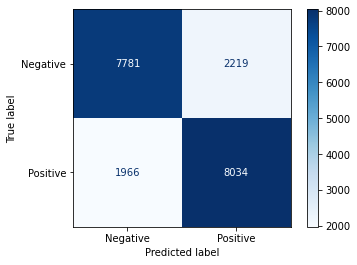

In [ ]:
from sklearn.metrics import plot_confusion_matrix
class_names = ['Negative', 'Positive']
plot_confusion_matrix(svm_best, X_test, y_test,display_labels=class_names,normalize=None, values_format = '.0f',cmap=plt.cm.Blues)

# Q3

## collect 15,000 tweets from Twitter about covid19

In [ ]:
!pip3 install tweepy

In [ ]:
import tweepy
from tweepy import OAuthHandler

consumer_key = 'rxYitNjUALeBSYVhStVXY1y5O'
consumer_secret = 'ZmxahUlNpw24m5yZEe2wqeWFMs6chiuPo7hV4aATwtSMNewnYR'
access_token = '1348193068047101953-3Xfwbuhf94B6EiH3Rj16G1g1ri1Ff0'
access_secret = 'NFVoDqtpG9uyXm1vWIH2U5ZFmpOdiY9W1gYyvcIu7y4fd'

auth = OAuthHandler(consumer_key,consumer_secret)
auth.set_access_token(access_token,access_secret)
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth)

In [ ]:
import tweepy
import time
#override tweepy.StreamListener to add logic to on_status
class MyStreamListener(tweepy.StreamListener):
  def __init__(self, time_limit=60):
        self.start_time = time.time()
        self.limit = time_limit
        super(MyStreamListener, self).__init__()

  def on_data(self, data):
        try:
          if (time.time() - self.start_time) < self.limit:
            with open('covid_1102.json', 'a') as f:
                f.write(data)
                return True
          else:
            return False  

        except BaseException as e:
            print("Error on_data: %s" % str(e))
        return True
        
  def on_error(self, status):
        print(status)
        return True

In [ ]:
myStreamListener = MyStreamListener(time_limit=30*60)
# time limit in seconds
myStream = tweepy.Stream(auth = api.auth, listener=myStreamListener, timeout=60)

In [ ]:
myStream.filter(languages=["en"], track=['covid'])

## build tweet dataframe and do pre-processing

In [ ]:

f_0802= "/content/drive/My Drive/covid_0802.json"
f_0902="/content/drive/My Drive/covid_0902.json"
f_1002="/content/drive/My Drive/covid_1002.json"
f_1102="/content/drive/My Drive/covid_1102.json"
f_1202="/content/drive/My Drive/covid_1202.json"
f_1302="/content/drive/My Drive/covid_1302.json"

file_list=[f_0802,f_0902,f_1002,f_1102,f_1202,f_1302]

dates=[]
tweets=[]
for fname in file_list:
  with open(fname, 'r',encoding="utf-8") as f:
    print(fname)
    for line in f:
        if len(line) < 10:
            continue
        try:
          tweet = json.loads(line)
          # tweet= clean_emoji(tweet)
          terms_all = [term for term in preprocess(tweet['text'],True) if term not in stop]
          # terms_all=[term for term in tweet.split() if term!=''] # check !!! 
          if '' in terms_all:
            terms_all.remove('')
          curr_tweet=' '.join(terms_all)
          tweets.append(curr_tweet)
          dates.append(tweet['created_at'])
        except:
          print(tweet)


/content/drive/My Drive/covid_0802.json
{'limit': {'track': 3, 'timestamp_ms': '1612799552697'}}
{'limit': {'track': 15, 'timestamp_ms': '1612800096113'}}
/content/drive/My Drive/covid_0902.json
/content/drive/My Drive/covid_1002.json
/content/drive/My Drive/covid_1102.json
{'limit': {'track': 20, 'timestamp_ms': '1613055606981'}}
{'limit': {'track': 21, 'timestamp_ms': '1613055608111'}}
/content/drive/My Drive/covid_1202.json
{'created_at': 'Sat Feb 12 16:32:52 +0000 2021', 'id': 1360628013801623558, 'id_str': '1360628013801623558', 'text': 'Highs of below 0 and more snow in eastern Iowa but registration is open for @PitchHitRun in Dubuque on April 17.  C… https://t.co/HreVnerLVw', 'source': '<a href="https://mobile.twitter.com" rel="nofollow">Twitter Web App</a>', 'truncated': True, 'in_reply_to_status_id': None, 'in_reply_to_status_id_str': None, 'in_reply_to_user_id': None, 'in_reply_to_user_id_str': None, 'in_reply_to_screen_name': None, 'user': {'id': 1663743774, 'id_str': '16637

In [ ]:
#create df
collected_tweets= pd.DataFrame()
collected_tweets['Date']=dates
collected_tweets['text']=tweets

In [ ]:
collected_tweets

,Date,text
0,Mon Feb 08 15:33:06 +0000 2021,@apqc half organizations workforce planning we...
1,Mon Feb 08 15:33:06 +0000 2021,@danadonly annoying covid made drink wine w 5 ...
2,Mon Feb 08 15:33:06 +0000 2021,@lisa_mcnally1 covid 19 messages sandwell's co...
3,Mon Feb 08 15:33:06 +0000 2021,negative
4,Mon Feb 08 15:33:06 +0000 2021,@mets citi field open mass covid vaccination s...
...,...,...
151375,Sat Feb 13 19:42:46 +0000 2021,@henniganp heno reckon pretend football cancel...
151376,Sat Feb 13 19:42:46 +0000 2021,@therustler83 #foi returned 6 @nhsuk boards #s...
151377,Sat Feb 13 19:42:46 +0000 2021,@jayztwocents hope feel better soon covid sucks
151378,Sat Feb 13 19:42:46 +0000 2021,@diannemstewart i'm best day since covid force...


In [ ]:
collected_tweets['Date']=pd.to_datetime(collected_tweets['Date'])
all_tweets= collected_tweets.copy()

In [ ]:
collected_tweets.nunique()

Date    10631
text    78600
dtype: int64

In [ ]:

collected_tweets= collected_tweets.drop_duplicates(subset=['text'], keep='first')

In [ ]:
#collected_tweets.to_csv("try.csv")

##  sentiment classification 

We label the collected tweets sentiment by using  dictionaries - positive and negative that we built.

We manually built two dictionaries - a positive dictionary and a negative dictionary.

We built the dictionary as follows:
* From the most popular words from the tweets we classified in question 1, we manually selected the ones that seemed most positive / negative to us and added them to the relevant dictionary.
* We found the most popular words in the tweets we collected from Twitter and categorized them as positive or negative as we saw fit.
* We added negative charges and emojis for every dictionary.
* We added more positive and negative words to each dictionary that seemed relevant to the field.

* Labeling explanation:
1 -> for labaling positive tweet . 
0 -> for labaling negative tweet .

* create positive and negative dictionarys

In [ ]:
# create pos and neg dictionaries - words from Q1 
# select relevant 20 pos\neg terms 
#pos : 
pos_top_70= pos_counter.most_common(70)
pos_top_70

[('good', 3990),
 ("i'm", 3486),
 ('quot', 2867),
 ('day', 2818),
 ('love', 2708),
 ('like', 2375),
 ('get', 2248),
 ('thanks', 2141),
 ('going', 2051),
 ('lol', 2006),
 ('today', 1934),
 ('time', 1917),
 ('go', 1749),
 ('great', 1723),
 ('new', 1701),
 ('one', 1676),
 ('u', 1667),
 ('got', 1612),
 ('twitter', 1600),
 ('see', 1581),
 ('know', 1580),
 ('back', 1521),
 ('well', 1514),
 ('amp', 1514),
 ('morning', 1491),
 ('night', 1430),
 ('work', 1301),
 ('2', 1296),
 ('hope', 1257),
 ('think', 1251),
 ('nice', 1250),
 ('really', 1225),
 ('fun', 1193),
 ('happy', 1189),
 ('im', 1188),
 ('haha', 1148),
 ('oh', 1058),
 ('much', 1045),
 ('3', 1036),
 ('home', 951),
 ("i'll", 914),
 ('thank', 914),
 ('still', 912),
 ('would', 902),
 ('hey', 877),
 ("can't", 869),
 ('awesome', 846),
 ('need', 844),
 ('yes', 835),
 ("that's", 803),
 ('way', 801),
 ('right', 798),
 ('wait', 789),
 ('better', 787),
 ('tomorrow', 786),
 ('watching', 773),
 ('want', 769),
 ('come', 763),
 ('getting', 758),
 ('las

In [ ]:
pos_dic=['good', 'love', 'like',' thanks',' lol',' great',' well','better','hope','nice',' fun',' happy',' haha',' thank',' yes',' awesome', 'yeah','best', 'cool']
len(pos_dic)

19

In [ ]:
# neg : 
neg_top_70= neg_counter.most_common(70)
neg_top_70

[("i'm", 4392),
 ('work', 3451),
 ('go', 3096),
 ('get', 2861),
 ('day', 2815),
 ('today', 2614),
 ('back', 2606),
 ('like', 2446),
 ('going', 2226),
 ('got', 2161),
 ("can't", 1979),
 ('still', 1931),
 ('good', 1890),
 ('really', 1870),
 ('2', 1855),
 ('want', 1830),
 ('time', 1817),
 ('im', 1720),
 ('one', 1633),
 ('quot', 1602),
 ('sad', 1511),
 ('last', 1504),
 ('sleep', 1473),
 ('miss', 1453),
 ('know', 1452),
 ('home', 1438),
 ('night', 1433),
 ('need', 1396),
 ('wish', 1376),
 ('oh', 1365),
 ('think', 1354),
 ('tomorrow', 1324),
 ('school', 1290),
 ('much', 1288),
 ('lol', 1269),
 ('morning', 1265),
 ('bad', 1237),
 ('well', 1230),
 ('feel', 1216),
 ('sorry', 1215),
 ('amp', 1209),
 ('see', 1203),
 ('u', 1187),
 ('3', 1032),
 ('hate', 1010),
 ('bed', 981),
 ('though', 977),
 ('sick', 974),
 ('love', 950),
 ('twitter', 917),
 ('getting', 908),
 ('hope', 901),
 ('would', 883),
 ('right', 882),
 ('new', 879),
 ('week', 817),
 ('tired', 814),
 ('could', 811),
 ('even', 778),
 ('4', 

In [ ]:
neg_dic=['cant','sad','last', 'miss','oh','bad','sorry','hate','tired','cant','dont']
len(neg_dic)

11

In [ ]:
# add smileies for each dic
pos_smiley= [ ':)', ':-)',':]',':p',':D','👍🏻','😀', '😃','😄','😁','😆','😅','🤣','😂','🙂' ,'😉','😊','😇','🥰','😍','🤩','😘','😋','😛','😜','🤪','😝','🤗','🥳','😎' ]
neg_smiley=[ ':(', ':-(',':[','👎🏻','🤐','🤨','😐','😑','😶','😒','🤥','😌','😔','😪','😷','🤒','🤕','🤢' ,'🤮','🤧','🥵','🥶','🥴','😵','😕','😟','🙁','☹️','😮','😯','😲','🥺','😦','😧','😰','😥','😢','😭','😱','😖','😣','💀','☠️']

pos_dic.extend(pos_smiley)
neg_dic.extend(neg_smiley)

# add emoji names : 
pos_smiley_word= [':smile:',':simple_smile:',':+1:',':thumbsup:',':laughing:',':laughing:',':laughing:',':blush:',':smiley:',':relaxed:',':smirk:',':heart_eyes:',':kissing_heart:',':kissing_closed_eyes:',':alien:',':relieved:',':satisfied:',':wink:',':stuck_out_tongue','_winking_eye:',':stuck_out_tongue_closed_eyes:',':grinning:',':kissing:',':kissing_smiling_eyes:',':stuck_out_tongue:',':joy:',':yum:',':sunglasses:']
neg_smiley_word=[':skull:',':worried:',':frowning:',':anguished:',':open_mouth:',':confused:',':hushed:',':expressionless:',':unamused:',':sweat:',':disappointed_relieved:',':weary:',':pensive:',':disappointed:',':confounded:',':fearful:',':cold_sweat:',':persevere:',':cry:',':sob:',':astonished:',':scream:',':neckbeard:',':tired_face:',':angry:',':rage:',':triumph:',':sleepy:',':mask:',':dizzy_face:',':neutral_face:',':no_mouth:',':thumbsdown:',':-1:',':flushed:',':grin:']
            
pos_dic.extend(pos_smiley_word)
neg_dic.extend(neg_smiley_word)


In [ ]:
# Terms Counting - count how many times term appears
def only_count(curr_df):
    count_all = Counter()
    for index, row in curr_df.iterrows():
        if 'Text' in curr_df.columns:
          curr_tweet = row['Text']
        elif 'text' in curr_df.columns:
          curr_tweet = row['text']
        if len(curr_tweet) < 1:
            continue
         # Create a list with all the terms
        curr_tweet = emoji.demojize(curr_tweet)
        curr_tweet_tokens = preprocess(curr_tweet, True)
        terms_all = [term for term in curr_tweet_tokens if term not in stop]
        if '' in terms_all:
          terms_all.remove('')
        # Update the counter
        count_all.update(terms_all)

    return count_all

In [ ]:
# select manualy positive and negative words from the most common words in collected tweets $$$$$ 
tweets_counter= only_count(collected_tweets)
common_terms_tweets= tweets_counter.most_common(100)
common_terms_tweets 

[('covid', 42510),
 ('19', 15204),
 ('vaccine', 5942),
 ('people', 5161),
 ('new', 3801),
 ('get', 3380),
 ('amp', 3329),
 ('like', 2556),
 ('cases', 2405),
 ('one', 2305),
 ('health', 2178),
 ('us', 2175),
 ('pandemic', 1984),
 ('deaths', 1921),
 ('would', 1876),
 ('vaccines', 1831),
 ('need', 1823),
 ('2', 1776),
 ('year', 1757),
 ('know', 1730),
 ('time', 1683),
 ('first', 1673),
 ('still', 1643),
 ('1', 1613),
 ('relief', 1600),
 ('going', 1599),
 ('”', 1591),
 ('today', 1571),
 ('news', 1480),
 ('many', 1467),
 ('says', 1432),
 ('day', 1398),
 ('go', 1390),
 ('uk', 1385),
 ('could', 1385),
 ('got', 1382),
 ('last', 1352),
 ('government', 1336),
 ('even', 1329),
 ('think', 1309),
 ('world', 1290),
 ('work', 1283),
 ('vaccination', 1282),
 ('#covid19', 1280),
 ('back', 1257),
 ('th', 1245),
 ('due', 1235),
 ('good', 1231),
 ('see', 1225),
 ('please', 1221),
 ('test', 1158),
 ('help', 1148),
 ('died', 1120),
 ('biden', 1115),
 ('week', 1102),
 ('want', 1097),
 ('getting', 1082),
 ('v

In [ ]:
collected_tweets

,Date,text
0,2021-02-08 15:33:06+00:00,@apqc half organizations workforce planning we...
1,2021-02-08 15:33:06+00:00,@danadonly annoying covid made drink wine w 5 ...
2,2021-02-08 15:33:06+00:00,@lisa_mcnally1 covid 19 messages sandwell's co...
3,2021-02-08 15:33:06+00:00,negative
4,2021-02-08 15:33:06+00:00,@mets citi field open mass covid vaccination s...
...,...,...
151366,2021-02-13 19:42:46+00:00,@drdavidfriedman interview one world leading a...
151372,2021-02-13 19:42:46+00:00,@chronus8 @talkradio @mikeparry8 listening lbc...
151373,2021-02-13 19:42:46+00:00,contesting speeding ticket
151375,2021-02-13 19:42:46+00:00,@henniganp heno reckon pretend football cancel...


In [ ]:
# pos and neg terms from our collectes tweets 
pos_tweets_dic=['please','relief','live']
neg_tweets_dic=['pandemic','deaths','died']
# add to suitable dic  - check acc ! if better
pos_dic.extend(pos_tweets_dic)
neg_dic.extend(neg_tweets_dic)

In [ ]:
# add our words 
our_pos= ['awesome', 'outstanding', 'impressive','victory','green']
our_neg=['terrible', 'crap' , 'useless','miserable','red','worst']
# add to suitable dic 
pos_dic.extend(our_pos)
neg_dic.extend(our_neg)

In [ ]:
global pos_count
global nut_count
global neg_count

pos_count=0
nut_count=0
neg_count=0

In [ ]:
# calc sentiment of tweets and classified: 1-> positive, 0->negative. 
def calc_tweet_sentimant(df):
  global pos_count
  global nut_count
  global neg_count
  dates=[]
  tweets=[]
  sentiments=[]
  for (indx,row) in df.iterrows():
    positive_counter=0
    negative_counter=0
    # go over all the words in tweet and check if they exist in the dics
    for term in row.text:
      if term in pos_dic:
        positive_counter+=1
      elif term in neg_dic:
        negative_counter+=1
    #compute score for whole tweet
    score= positive_counter - negative_counter
    if score>0:# positive sentimant
      pos_count=pos_count+1
      dates.append(row['Date'])
      tweets.append(row['text'])
      sentiments.append(1)
    elif score<0:# negative sentimant
      neg_count+=1
      dates.append(row['Date'])
      tweets.append(row['text'])
      sentiments.append(0)
    else:# nutruel sentimant -> not classified 
      nut_count+=1
  
  ans=pd.DataFrame()
  ans['date']=dates
  ans['text']=tweets
  ans['target']=sentiments

  return ans

In [ ]:

classified_tweets=calc_tweet_sentimant(collected_tweets)

In [ ]:
print(pos_count,nut_count,neg_count)

881 76926 793


In [ ]:
classified_tweets

,date,text,target
0,2021-02-08 15:33:11+00:00,@kmatyler last real gathering place covid 😭,0
1,2021-02-08 15:33:12+00:00,sports ball 🤣 🤣 🤣 #superspreaderbowl #covid #s...,1
2,2021-02-08 15:33:14+00:00,@kasoa_mayor pls anyone else joining take covi...,1
3,2021-02-08 15:33:17+00:00,@_f__ire said nothing would come us covid 😔,0
4,2021-02-08 15:33:22+00:00,@lailagilden3 spending 120 million rands covid...,1
...,...,...,...
1669,2021-02-13 19:42:07+00:00,@n4chtvrnvs @goonermetalhead need covid testin...,1
1670,2021-02-13 19:42:29+00:00,hope 🙁,0
1671,2021-02-13 19:42:36+00:00,@marrgarritah covid dey catch police 😭,0
1672,2021-02-13 19:42:39+00:00,last year got dozen roses work 🤷 🏻 ‍ ♀ ️ year ...,1


In [ ]:
# split collected_tweets to 2 ds - positive and negative 
pos_covid_tweets=classified_tweets.query('target == 1')
neg_covid_tweets=classified_tweets.query('target == 0')


## Analyze the most popular terms

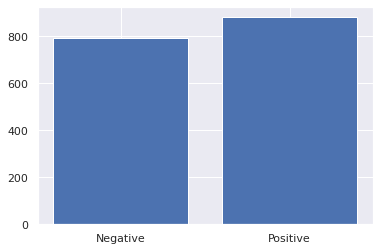

In [ ]:
# positive and negative distribution :
tweets_class_count = classified_tweets.groupby(['target'])['target'].count()
plt.bar(np.array(["Negative","Positive"]),tweets_class_count)
plt.show()

* Find most common words for positive and negative sentiments:

positive collected tweets:

In [ ]:
pos_covid_tweets.head()

,date,text,target
1,2021-02-08 15:33:12+00:00,sports ball 🤣 🤣 🤣 #superspreaderbowl #covid #s...,1
2,2021-02-08 15:33:14+00:00,@kasoa_mayor pls anyone else joining take covi...,1
4,2021-02-08 15:33:22+00:00,@lailagilden3 spending 120 million rands covid...,1
11,2021-02-08 15:34:09+00:00,really questions super bowl going 😂 😂,1
13,2021-02-08 15:34:11+00:00,@catturd2 strange reason liberals really trigg...,1


In [ ]:
pos_covid_tweets.shape

(881, 3)

In [ ]:
# count positive terms frequency
pos_covid_tweets_counter= only_count(pos_covid_tweets)
print("Number of terms in positive category:",len(pos_covid_tweets_counter))

Number of terms in positive category: 3915


In [ ]:
# convert emoji description in words to emoji 
def convert_to_emoji(common_tweets):
  for i,e in enumerate(common_tweets):
    if e[0].find('_')!=(-1):
      curr_list=list(common_tweets[i])
      curr_list[0]=emoji.emojize(":{0}:".format(e[0]))
      common_tweets[i]=tuple(curr_list)


In [ ]:
# average length - positive
print('average length of positive post: {0}'.format(get_average_text_len(pos_covid_tweets)))
print()

#top 10 terms - positive - Finding 10 highest values

high_covid_tweets_pos = pos_covid_tweets_counter.most_common(10)
convert_to_emoji(high_covid_tweets_pos)
high_covid_tweets_pos


average length of positive post: 11.154370034052214



[('😂', 733),
 ('covid', 541),
 ('🤣', 358),
 ('19', 80),
 (':p', 80),
 ('😍', 59),
 ('vaccine', 53),
 ('like', 53),
 ('😊', 44),
 ('😅', 43)]

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 129315 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 129315 missing from current font.
  font.set_text(s, 0, flags=flags)


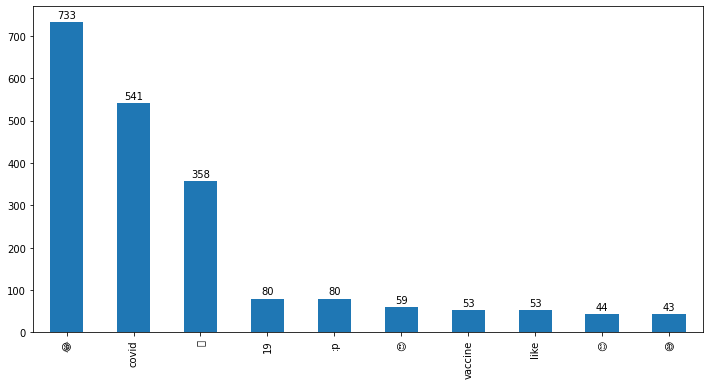

In [ ]:
  # positive top 10 terms plot
x_labels = [val[0] for val in high_covid_tweets_pos]
y_labels = [val[1] for val in high_covid_tweets_pos]
plt.figure(figsize=(12, 6))
ax = pd.Series(y_labels).plot(kind='bar')
ax.set_xticklabels(x_labels)

rects = ax.patches

for rect, label in zip(rects, y_labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

negative collected tweets:



In [ ]:
neg_covid_tweets.head()

,date,text,target
0,2021-02-08 15:33:11+00:00,@kmatyler last real gathering place covid 😭,0
3,2021-02-08 15:33:17+00:00,@_f__ire said nothing would come us covid 😔,0
5,2021-02-08 15:33:30+00:00,proud drivers part team spot super steph 😷 💪 🦸...,0
6,2021-02-08 15:33:34+00:00,@aboa_banku 457 covid 19 deaths 772 new cases ...,0
7,2021-02-08 15:33:37+00:00,@littleelfiies 100 k going choose fan fuck 🥵 w...,0


In [ ]:
neg_covid_tweets.shape

(793, 3)

In [ ]:
# count negative terms frequency
neg_covid_tweets_counter= only_count(neg_covid_tweets)
print("Number of terms in negative category:",len(neg_covid_tweets_counter))

Number of terms in negative category: 3335


In [ ]:
#top 10 terms - negative - Finding 10 highest values
high_covid_tweets_neg = neg_covid_tweets_counter.most_common(10)

convert_to_emoji(high_covid_tweets_neg)
high_covid_tweets_neg

[('covid', 517),
 ('😭', 473),
 (':p', 133),
 ('😷', 129),
 (':ensive_face:', 78),
 ('😢', 75),
 ('19', 74),
 ('skull', 60),
 ('get', 52),
 ('😱', 47)]

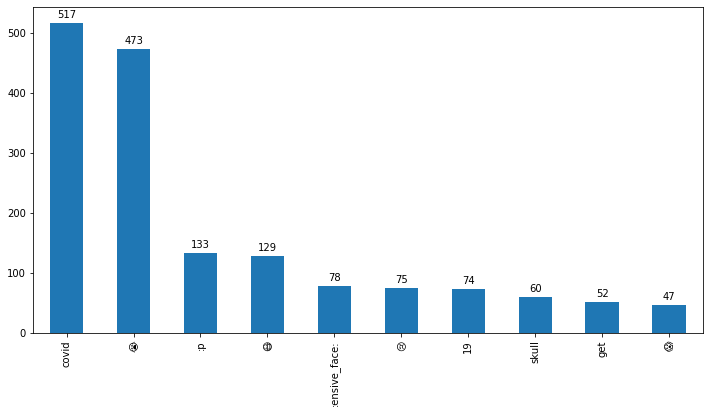

In [ ]:
# negative top 10 terms plot
x_labels = [val[0] for val in high_covid_tweets_neg]
y_labels = [val[1] for val in high_covid_tweets_neg]
plt.figure(figsize=(12, 6))
ax = pd.Series(y_labels).plot(kind='bar')
ax.set_xticklabels(x_labels)

rects = ax.patches

for rect, label in zip(rects, y_labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')


In [ ]:
# most popular terms for each class: 
top_tweets_df = pd.DataFrame()
top_tweets_df['Positive Tweets Terms']= high_covid_tweets_pos
top_tweets_df['Negative Tweets Terms']=high_covid_tweets_neg

top_tweets_df

,Positive Tweets Terms,Negative Tweets Terms
0,"(😂, 733)","(covid, 517)"
1,"(covid, 541)","(😭, 473)"
2,"(🤣, 358)","(:p, 133)"
3,"(19, 80)","(😷, 129)"
4,"(:p, 80)","(:ensive_face:, 78)"
5,"(😍, 59)","(😢, 75)"
6,"(vaccine, 53)","(19, 74)"
7,"(like, 53)","(skull, 60)"
8,"(😊, 44)","(get, 52)"
9,"(😅, 43)","(😱, 47)"


## Discuss the similarity with the train 
we can see that there is no high similarity between the common words in the training set and those in the test set.
The most commonly words we found in the training set dont contain emojis at all, however the common words in the test set consists mostly of emojis. On the other hand, it can be seen that there are single words that were found in both the training set and the test set - like the words: like in the positive terms, get in the negative terms.
 
 - We will discuss the common words we found:

we can see that most of the common words we have found (positive and negative) are emojis. After all, emojis characterize the type of writing that is common in Twitter and even clearly show positives or negatives. For this reason we chose to add emojis to the dictionaries we created. The emojis that appear in the positive concepts are those of a positive and happy nature while those that appear in the negative concepts are of a negative and sad nature. In addition, it can be seen that the word "covid" is common in both dictionaries because it is the word on which we performed the search. It can be seen that, the word "vaccine" is among the common positive words because it deals with the path to the solution of the virus and even the end of the plague. The word "skull" is a word of a negative nature associated with death and so we can see that we have found it to be common in words labeled as negative.

# Q4


In [ ]:
classified_tweets

,date,text,target
0,2021-02-08 15:33:11+00:00,@kmatyler last real gathering place covid 😭,0
1,2021-02-08 15:33:12+00:00,sports ball 🤣 🤣 🤣 #superspreaderbowl #covid #s...,1
2,2021-02-08 15:33:14+00:00,@kasoa_mayor pls anyone else joining take covi...,1
3,2021-02-08 15:33:17+00:00,@_f__ire said nothing would come us covid 😔,0
4,2021-02-08 15:33:22+00:00,@lailagilden3 spending 120 million rands covid...,1
...,...,...,...
1669,2021-02-13 19:42:07+00:00,@n4chtvrnvs @goonermetalhead need covid testin...,1
1670,2021-02-13 19:42:29+00:00,hope 🙁,0
1671,2021-02-13 19:42:36+00:00,@marrgarritah covid dey catch police 😭,0
1672,2021-02-13 19:42:39+00:00,last year got dozen roses work 🤷 🏻 ‍ ♀ ️ year ...,1


Accuracy score: 0.581242532855436


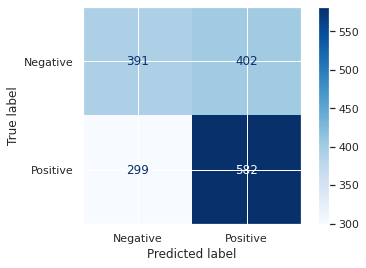

In [ ]:
#X_tweets= tf_vec.transform(classified_tweets['text'])

preds = svm_best.predict(classified_tweets['text'].tolist())
print("Accuracy score:",metrics.accuracy_score(classified_tweets['target'], preds))

class_names = ['Negative', 'Positive']
plot_confusion_matrix(svm_best, classified_tweets['text'].tolist(), classified_tweets['target'],display_labels=class_names,normalize=None, values_format = '.0f',cmap=plt.cm.Blues)

In [ ]:
print(metrics.classification_report(classified_tweets['target'], preds))

              precision    recall  f1-score   support

           0       0.57      0.49      0.53       793
           1       0.59      0.66      0.62       881

    accuracy                           0.58      1674
   macro avg       0.58      0.58      0.58      1674
weighted avg       0.58      0.58      0.58      1674



# Q5


לבדוק מה קורלייטד מה לא? להשוות לאירוע שקרה בעולם האמיתי בתקופה זו 

5-a : Aggregate the tweets you collected per day


In [ ]:
all_tweets.dtypes

Date    datetime64[ns, UTC]
text                 object
dtype: object

In [ ]:
all_tweets


,Date,text
0,2021-02-08 15:33:06+00:00,@apqc half organizations workforce planning we...
1,2021-02-08 15:33:06+00:00,@danadonly annoying covid made drink wine w 5 ...
2,2021-02-08 15:33:06+00:00,@lisa_mcnally1 covid 19 messages sandwell's co...
3,2021-02-08 15:33:06+00:00,negative
4,2021-02-08 15:33:06+00:00,@mets citi field open mass covid vaccination s...
...,...,...
151375,2021-02-13 19:42:46+00:00,@henniganp heno reckon pretend football cancel...
151376,2021-02-13 19:42:46+00:00,@therustler83 #foi returned 6 @nhsuk boards #s...
151377,2021-02-13 19:42:46+00:00,@jayztwocents hope feel better soon covid sucks
151378,2021-02-13 19:42:46+00:00,@diannemstewart i'm best day since covid force...


In [ ]:
all_tweets['Date']=all_tweets['Date'].dt.date

In [ ]:
all_tweets.head()

,Date,text
0,2021-02-08,@apqc half organizations workforce planning we...
1,2021-02-08,@danadonly annoying covid made drink wine w 5 ...
2,2021-02-08,@lisa_mcnally1 covid 19 messages sandwell's co...
3,2021-02-08,negative
4,2021-02-08,@mets citi field open mass covid vaccination s...


In [ ]:
all_tweets_by_days=all_tweets.groupby(['Date'])['Date'].count()

In [ ]:
all_tweets_by_days

Date
2021-02-08    26657
2021-02-09    18135
2021-02-10    19548
2021-02-11    29416
2021-02-12    27563
2021-02-13    30061
Name: Date, dtype: int64

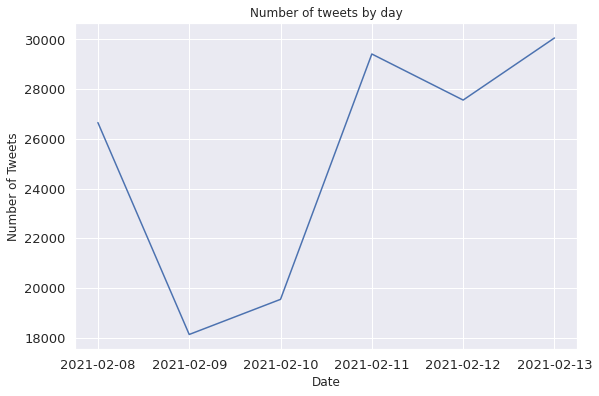

In [ ]:
# Let's draw

sns.set(color_codes=True)
dx = all_tweets_by_days.plot.line(figsize = (9,6), title = "Number of tweets by day")
dx.set_xlabel('Date')
dx.set_ylabel('Number of Tweets')
dx.tick_params(axis='both', which='major', labelsize=13)



### positive tweets

In [ ]:
all_tweets_pred = svm_best.predict(all_tweets['text'].tolist())
print((all_tweets_pred== 0).sum())
print((all_tweets_pred== 1).sum())

51526
99854


In [ ]:
all_tweets['target']=all_tweets_pred
all_tweets.head()

,Date,text,target
0,2021-02-08,@apqc half organizations workforce planning we...,1
1,2021-02-08,@danadonly annoying covid made drink wine w 5 ...,0
2,2021-02-08,@lisa_mcnally1 covid 19 messages sandwell's co...,0
3,2021-02-08,negative,1
4,2021-02-08,@mets citi field open mass covid vaccination s...,1


In [ ]:
positive_collected= all_tweets[all_tweets['target']==1]
positive_collected

,Date,text,target
0,2021-02-08,@apqc half organizations workforce planning we...,1
3,2021-02-08,negative,1
4,2021-02-08,@mets citi field open mass covid vaccination s...,1
6,2021-02-08,@michele_norris moms carry burden opposite-sex...,1
7,2021-02-08,@kelliekelly23 south africa halt planned rollo...,1
...,...,...,...
151369,2021-02-13,@margostockdale ok put,1
151371,2021-02-13,@clarajeffery 1 catching mcconnell made clear ...,1
151372,2021-02-13,@chronus8 @talkradio @mikeparry8 listening lbc...,1
151376,2021-02-13,@therustler83 #foi returned 6 @nhsuk boards #s...,1


In [ ]:
pos_tweets_by_days=positive_collected.groupby(['Date'])['Date'].count()

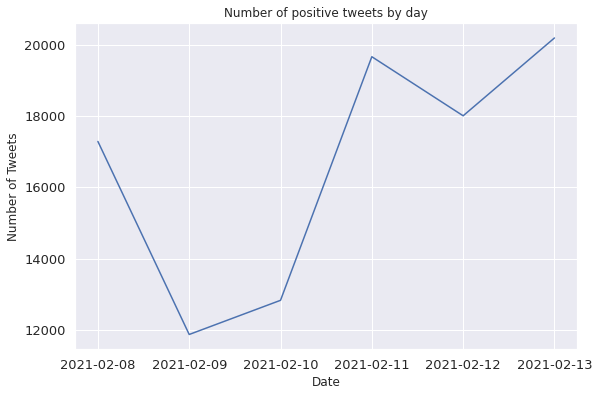

In [ ]:
# Let's draw

sns.set(color_codes=True)
dx = pos_tweets_by_days.plot.line(figsize = (9,6), title = "Number of positive tweets by day")
dx.set_xlabel('Date')
dx.set_ylabel('Number of Tweets')
dx.tick_params(axis='both', which='major', labelsize=13)



In [ ]:
by_days = pd.concat([all_tweets_by_days, pos_tweets_by_days],axis=1)


In [ ]:
by_days.columns=['All tweets', 'Pos tweets']
by_days

,All tweets,Pos tweets
Date,,
2021-02-08,26657,17287
2021-02-09,18135,11875
2021-02-10,19548,12833
2021-02-11,29416,19663
2021-02-12,27563,18007
2021-02-13,30061,20189


## google trends tweets

In [ ]:
!pip install pytrends


In [ ]:
from pytrends.request import TrendReq
pytrend = TrendReq()
pytrend.build_payload(kw_list=['covid'], timeframe='2021-02-08 2021-02-13')
interest_over_time_df = pytrend.interest_over_time()
print(interest_over_time_df)



            covid  isPartial
date                        
2021-02-08     97      False
2021-02-09     97      False
2021-02-10     98      False
2021-02-11     96      False
2021-02-12    100      False
2021-02-13     85      False


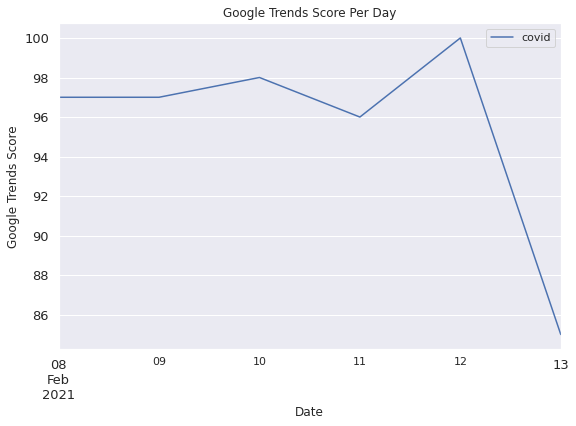

In [ ]:
# Let's draw

sns.set(color_codes=True)
dx = interest_over_time_df.plot.line(figsize = (9,6), title = "Google Trends Score Per Day")
dx.set_xlabel('Date')
dx.set_ylabel('Google Trends Score')
dx.tick_params(axis='both', which='major', labelsize=13)



In [ ]:
by_days = pd.concat([by_days, interest_over_time_df['covid']],axis=1)
by_days

,All tweets,Pos tweets,covid
2021-02-08,26657,17287,97
2021-02-09,18135,11875,97
2021-02-10,19548,12833,98
2021-02-11,29416,19663,96
2021-02-12,27563,18007,100
2021-02-13,30061,20189,85


In [ ]:
by_days.columns=['All tweets', 'Pos tweets','Google trends']


               All tweets  Pos tweets  Google trends
All tweets       1.000000    0.997877      -0.446932
Pos tweets       0.997877    1.000000      -0.486672
Google trends   -0.446932   -0.486672       1.000000


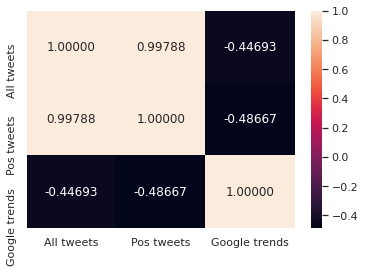

In [ ]:
corr=by_days.corr(method='pearson')
print(corr)
# make pretty!!!!!
import seaborn as sns
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values,
            annot=True,
            fmt=".5f")

In [ ]:
#normilize- min max scaling . 90-100 ??????

def min_max_scaling(col):
  max_old= col.max()
  min_old = col.min()
  max_new=100
  min_new=85
  new_col=[]
  for value in col:
    curr=(max_new-min_new)/(max_old-min_old)
    curr= curr* (value-max_old)
    curr= curr+max_new
    new_col.append(curr)
  return new_col

by_days['All tweets']= min_max_scaling(by_days['All tweets'])
by_days['Pos tweets']= min_max_scaling(by_days['Pos tweets'])

by_days

,All tweets,Pos tweets,Google trends
2021-02-08,95.718598,94.764253,97
2021-02-09,85.000000,85.000000,97
2021-02-10,86.777209,86.728410,98
2021-02-11,99.188747,99.050998,96
2021-02-12,96.858125,96.063267,100
2021-02-13,100.000000,100.000000,85


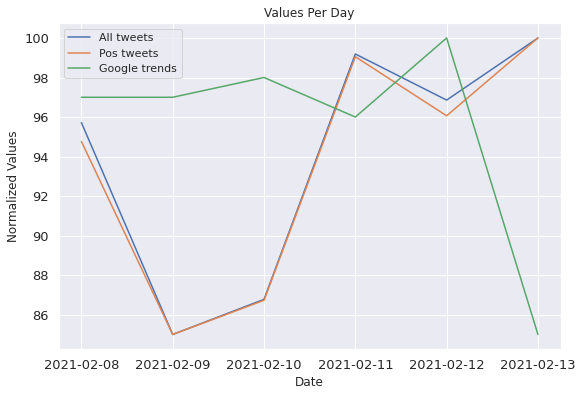

In [ ]:
sns.set(color_codes=True)
dx = by_days.plot.line(figsize = (9,6), title = "Values Per Day")
dx.set_xlabel('Date')
dx.set_ylabel('Normalized Values')
dx.tick_params(axis='both', which='major', labelsize=13)